# すべてのラベル付きウエハ　ラドン変換等

### Step1：解決すべき問題について
- 入力：WM-811K dataset
- モデル：一対一マルチクラスSVM
- 出力：不良パターンラベル

In [1]:
# loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline 

import os
print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

['LSWMD.pkl']


### Step2：データの準備
- データの選択と処理
- データの概要
- データの状態
- 欠損値のチェック
- その他

#### データの概要

In [2]:
df=pd.read_pickle("../input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


- データセットは811,457枚のウエハマップとウエハダイサイズ（実際のウエハの大きさ），ロット名，ウエハインデックスなどの情報から構成されている．
- トレーニングセットとテストセットは既に分割されている．
- このカーネルでは後述するホールドアウトメソッドによりデータセットをトレーニングセットとテストセットに再分割した．

#### データの状態

In [3]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [4]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


- このデータセットは実際の製品47,543ロットから収集したものである．
- しかし，47,543ロット×25枚/ロット=1,157,325枚のウエハマップは811,457枚のウエハマップより多い．
- データ数が少ない原因を調べる．

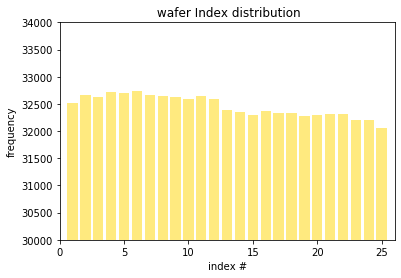

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

- この図から全てのロットで25枚のウエハマップが完全な状態でないことを示している．
- センサの故障や，その他の問題が原因と思われる．
- 今回の分類ではウエハのインデックスは必要としないので問題ない．削除をする．

In [6]:
df = df.drop(['waferIndex'], axis = 1)

- ウエハマップのそれぞれの列から得られる情報はないが，インスタンスごとにダイサイズが異なることがわかる．
- ウエハマップのダイサイズをチェックするための変数`WaferMapDim`を定義する．（縦，横の値）

In [7]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
438307,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1080.0,lot26488,[],[],"(35, 40)"
202936,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3947.0,lot12942,[],[],"(66, 77)"
715052,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1297.0,lot43630,[[Test]],[[none]],"(41, 41)"
145794,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",712.0,lot9379,[],[],"(30, 31)"
347386,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2,...",518.0,lot20759,[],[],"(27, 25)"


In [8]:
max(df.waferMapDim), min(df.waferMapDim)

((300, 202), (6, 21))

In [9]:
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]

632

In [10]:
for i in range(10):#uni_waferDim[0].shape[0]):
    wdim = uni_waferDim[0][i]
    sub_df = df.loc[df['waferMapDim'] == wdim]
    print(sub_df.head())

                                                 waferMap  dieSize   lotName  \
742367  [[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 0,...     79.0  lot44738   

       trianTestLabel failureType waferMapDim  
742367             []          []     (6, 21)  
                                                 waferMap  dieSize   lotName  \
674198  [[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0], [0, 0, 1, ...     82.0  lot41977   
674199  [[0, 0, 0, 2, 1, 2, 2, 1, 0, 0, 0], [0, 0, 1, ...     82.0  lot41977   
674200  [[0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0], [0, 0, 2, ...     82.0  lot41977   
674201  [[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0], [0, 0, 1, ...     82.0  lot41977   
674202  [[0, 0, 0, 1, 1, 2, 2, 2, 0, 0, 0], [0, 0, 2, ...     82.0  lot41977   

       trianTestLabel failureType waferMapDim  
674198             []          []    (10, 11)  
674199             []          []    (10, 11)  
674200             []          []    (10, 11)  
674201             []          []    (10, 11)  
674202             [] 

- ウエハマップの大きさは全て同じではなく，632種類ある．
- そのため，入力の次元を同じにするためのデータ変換が必要となる．

#### 欠損値のチェック

- 大規模なデータセットを扱うことに恐れてはいけない．データセットを見ると，かなりの数のデータが欠損値のために役立たないことがわかる．
- 欠損値のチェックはデータの作成時に重要となる．ここではパターンのあるウエハのみを対象としているため，欠損ラベルのないデータは取り除くこともある．

- 不良パターンと学習orテストラベルを数値で表す．

In [11]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [12]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [13]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

- テストデータと学習データの数を見る

In [14]:
for i in range(2):
    print(len(df[df['trainTestNum'] == i]))

54355
118595


- ラベルの内訳を見る

In [15]:
for i in range(9):
    print(len(df[df['failureNum']==i]))

4294
555
5189
9680
3593
866
1193
149
147431


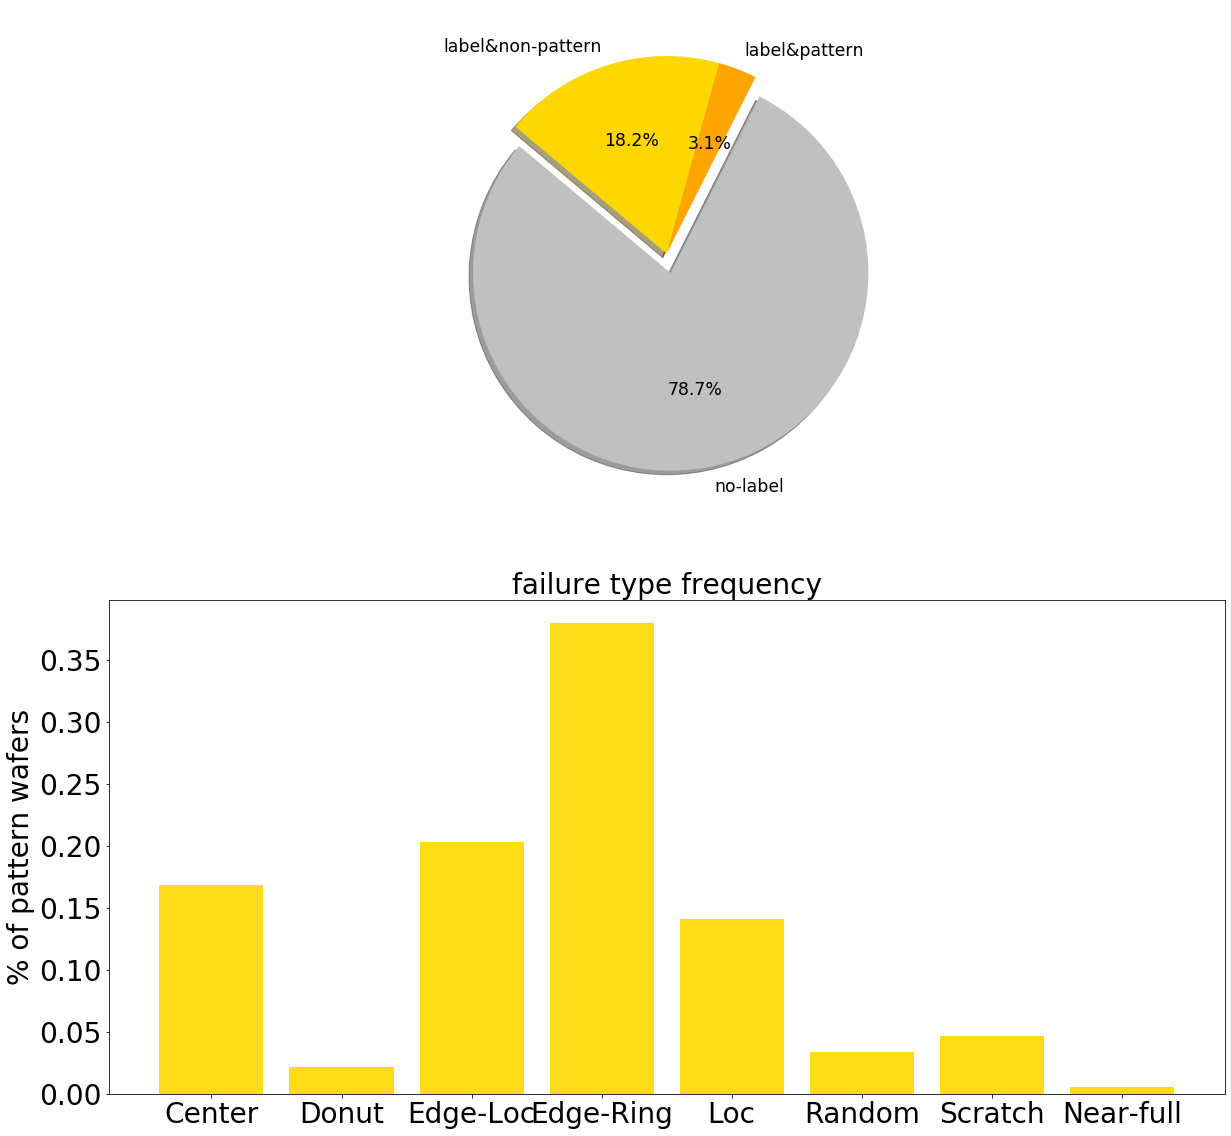

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 20)) 
gs = gridspec.GridSpec(2, 1) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140, textprops={'size': 'xx-large'})

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency", fontsize=28)
ax2.set_ylabel("% of pattern wafers", fontsize=28)
ax2.set_xticklabels(labels2, fontsize=28)

plt.tick_params(labelsize=28)
plt.show()

- 結果として，172,950枚のウエハは不良ラベルを持ち，78.7%のウエハは不良ラベルがない．
- また，ラベル付きのウエハのうち，実際に不良パターンがあるのは全体のわずか3.1%(25,519枚)であり，残りの147,431枚のウエハは不良パターンが`none`となっている．
- その結果，実際に不良パターンがあるのは3.1%(25,519枚）だけであり，計算量は大幅に削減される．
- 上の2つ目の図から，データセットは高い不均衡分布を示していることがわかる．

#### 百聞は一見に如かず

- 行列のデータを示す最も良い方法はデータを可視化することである．
- 不良パターンのラベル付けがされている100枚のサンプルを可視化する．

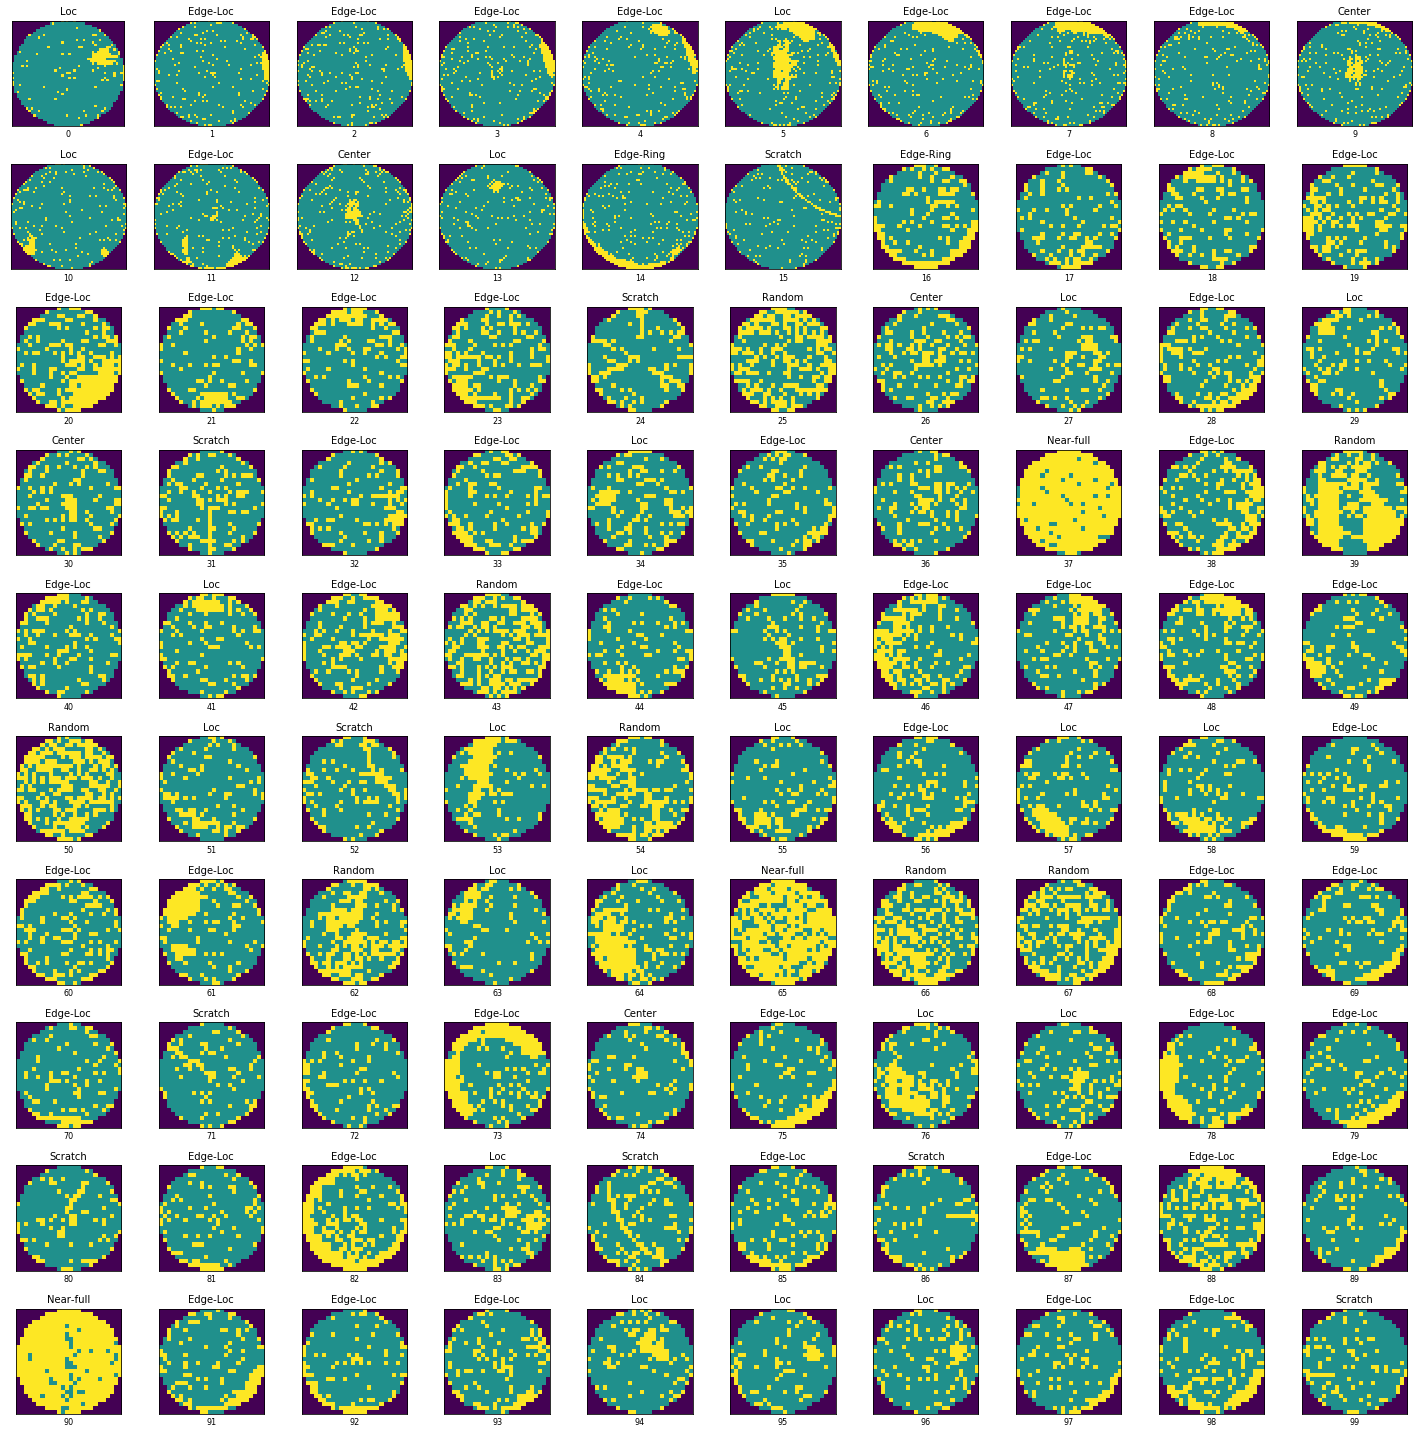

In [47]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=10)
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

- 不良パターンに基づいた形で可視化する．


***Center, Donut, Edge-Loc, Edge-Ring, Loc, Random, Scratch, Near-full***

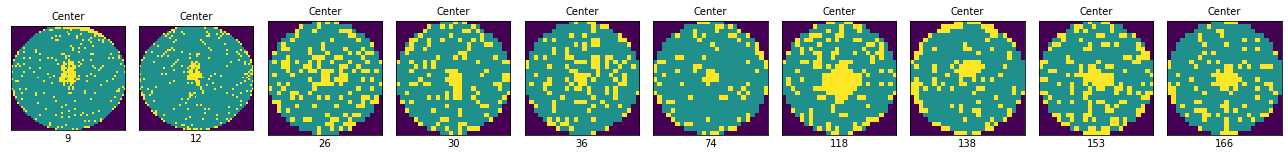

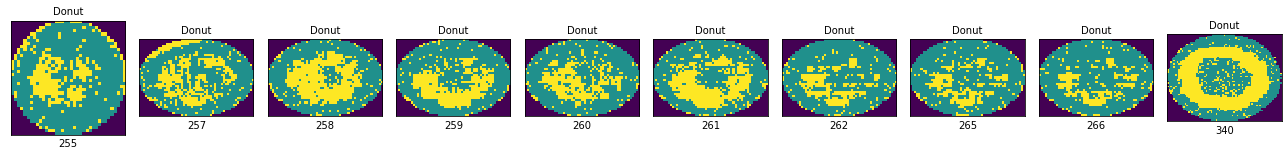

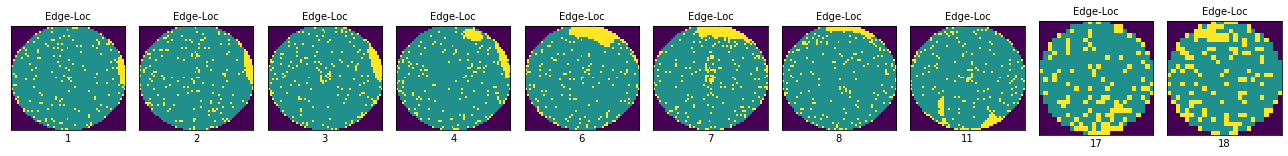

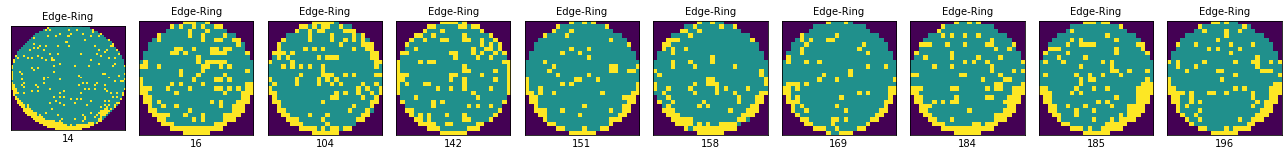

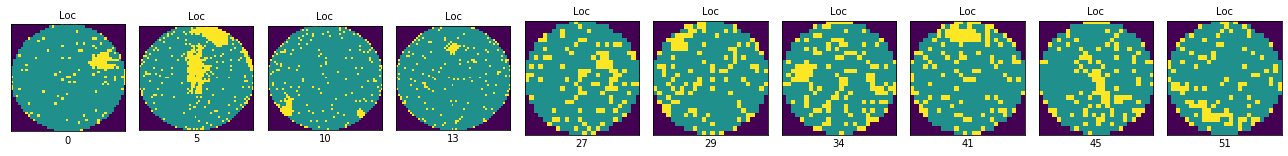

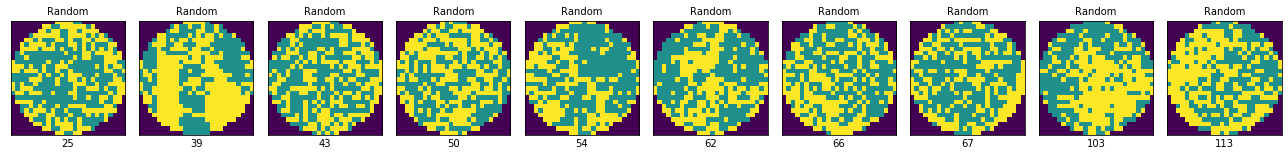

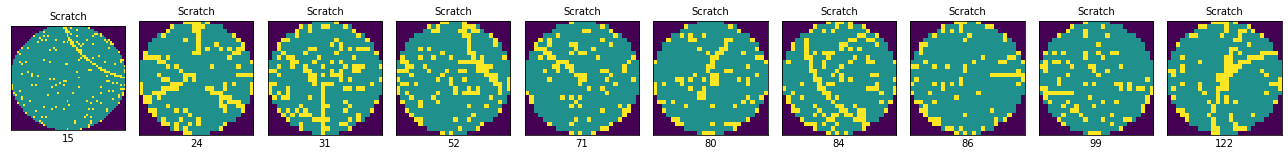

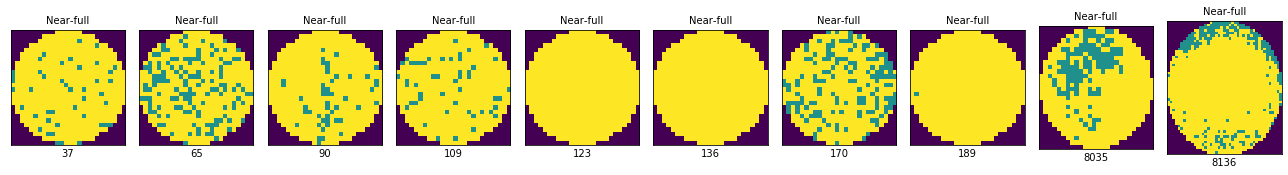

In [48]:
x = [0,1,2,3,4,5,6,7]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_withpattern.waferMap[df_withpattern.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_withpattern.failureType[img.index[i]][0][0], fontsize=10)
            ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

- それぞれの不良パターンから，最も典型的なウエハを可視化する．

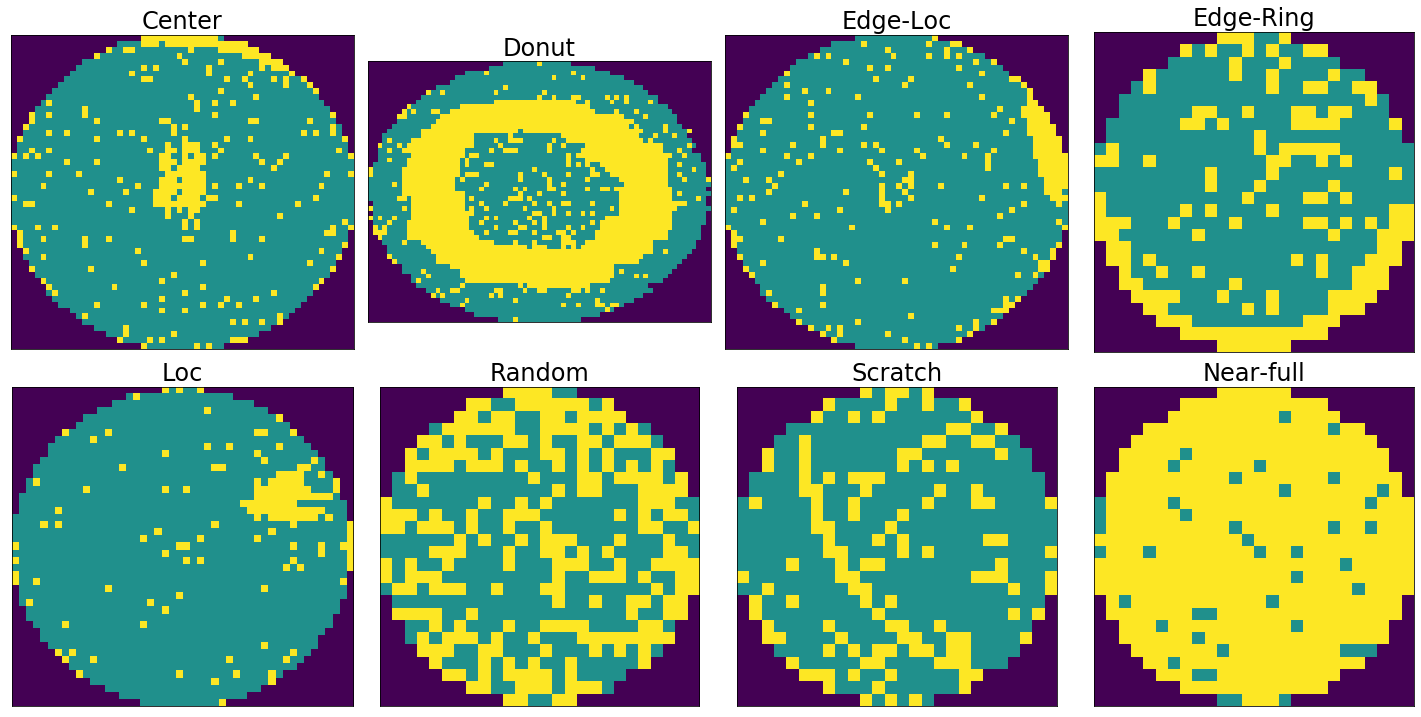

In [49]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

#ind_def = {'Center': 9, 'Donut': 340, 'Edge-Loc': 3, 'Edge-Ring': 16, 'Loc': 0, 'Random': 25,  'Scratch': 84, 'Near-full': 37}
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

### Step2：データの準備（続き）
- ***データの変形：***スケーリング，属性分解，属性集約することで前処理されたデータを聞かう学習ができる状態にする．

In [50]:
# loading libraries
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats

#### 密度特徴量（13次元）
- ウエハマップを13個の領域に分け，それに応じて欠陥密度を計算した．13の領域はウエハ内側の9つの領域と上下左右の4つの領域のことである．
- それぞれの不良パターンごとに，異なる密度分布を持つ．例えば不良パターン*Center*は9つの領域のうち中央の欠陥密度が高くなる．

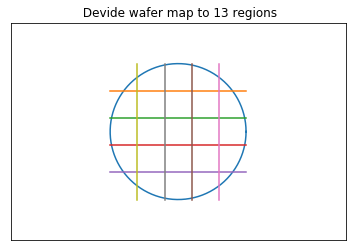

In [51]:
# illustration of 13 regions
an = np.linspace(0, 2*np.pi, 100)
plt.plot(2.5*np.cos(an), 2.5*np.sin(an))
plt.axis('equal')
plt.axis([-4, 4, -4, 4])
plt.plot([-2.5, 2.5], [1.5, 1.5])
plt.plot([-2.5, 2.5], [0.5, 0.5 ])
plt.plot([-2.5, 2.5], [-0.5, -0.5 ])
plt.plot([-2.5, 2.5], [-1.5,-1.5 ])

plt.plot([0.5, 0.5], [-2.5, 2.5])
plt.plot([1.5, 1.5], [-2.5, 2.5])
plt.plot([-0.5, -0.5], [-2.5, 2.5])
plt.plot([-1.5, -1.5], [-2.5, 2.5])
plt.title(" Devide wafer map to 13 regions")
plt.xticks([])
plt.yticks([])
plt.show()

上記の典型的な不良パターンを持つウエハの欠陥密度のヒストグラムを作成する．

In [52]:
def cal_den(x):
    return 100*(np.sum(x==2)/np.size(x))  

def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)
    
    reg1=x[ind1[0]:ind1[1],:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg2=x[:,ind2[4]:]

    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]
    
    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    return fea_reg_den

In [53]:
df_withpattern['fea_reg']=df_withpattern.waferMap.apply(find_regions)

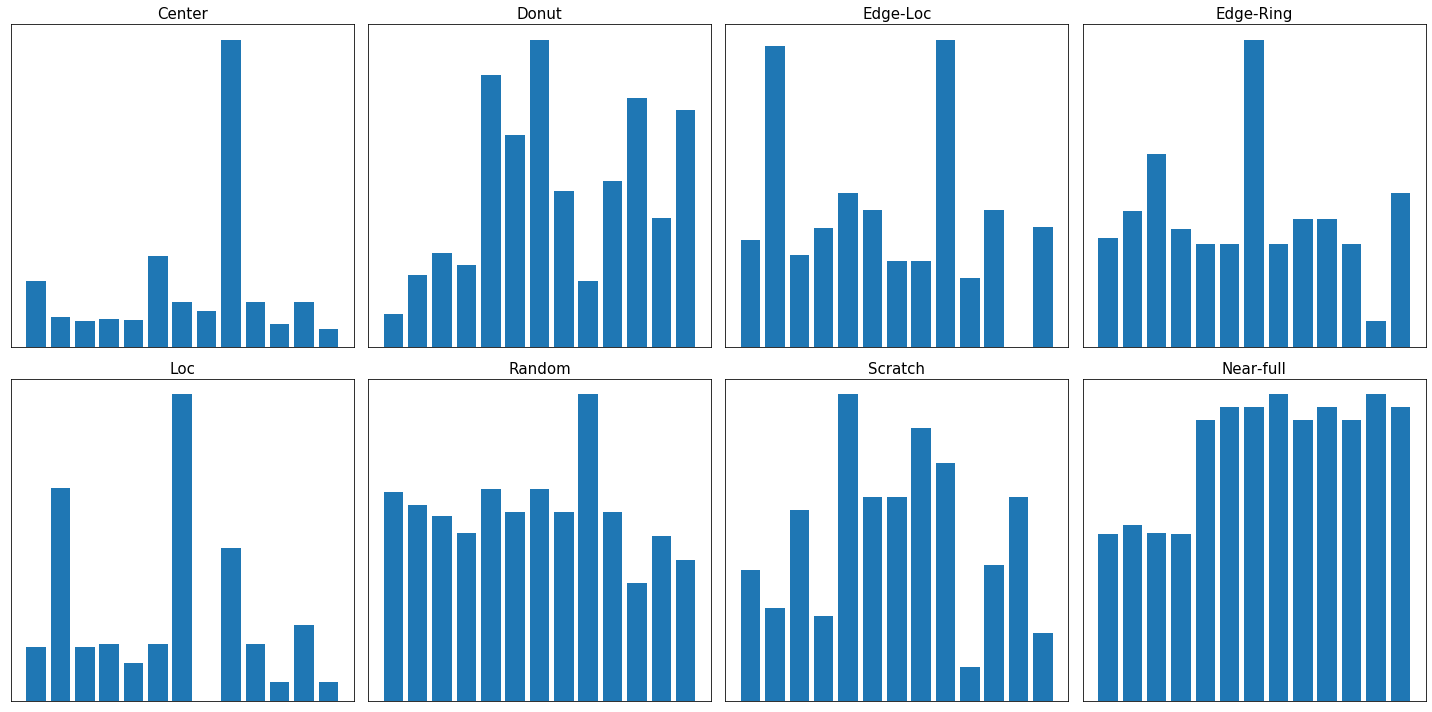

In [54]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,13,13),df_withpattern.fea_reg[x[i]])
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show() 

- 上のヒストグラムは8つの典型的な不良パターンの密度を示している．
- 密度に基づいた特徴量を抽出することで，データセットをより分類可能なものにしていることがわかる．

#### ラドン変換による特徴量（40次元）
- 一連の投影によって，二次元表現を生成することができる．

In [55]:
def change_val(img):
    img[img==1] =0  
    return img

df_withpattern_copy = df_withpattern.copy()
df_withpattern_copy['new_waferMap'] =df_withpattern_copy.waferMap.apply(change_val)

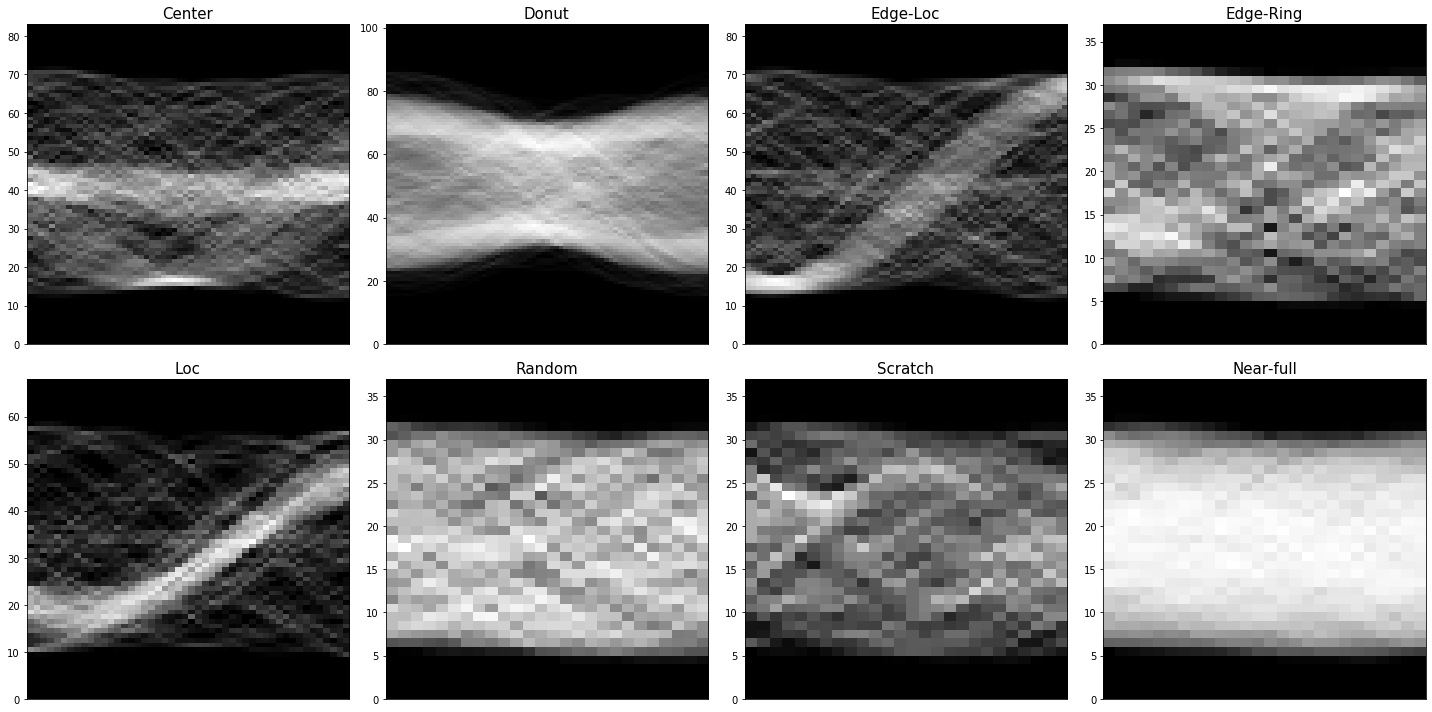

In [77]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta, circle=False)    
      
    ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()

plt.show() 

- 上記の図はラドン変換を8つの典型的な不良パターンについて行った結果である．
- しかし，ラドン変換を行った結果を得ることはできたが，ウエハには様々な大きさがあり，特徴を見出すことができない．
- 次のステップでは3次補間を用いて，ラドン変換から行平均と行標準偏差の固定された大きさの特徴量を求める．ここでそれぞれの大きさは20に固定する．
- 合計で40次元のラドン変換に基づく特徴量が抽出できる．

In [67]:
def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta, circle=False)
    xMean_Row = np.mean(sinogram, axis = 1)
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xMean_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew

def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta, circle=False)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew  

In [68]:
df_withpattern_copy['fea_cub_mean'] =df_withpattern_copy.waferMap.apply(cubic_inter_mean)
df_withpattern_copy['fea_cub_std'] =df_withpattern_copy.waferMap.apply(cubic_inter_std)

#### ラドン変換に基づく特徴量（行の平均値を加えたもの）

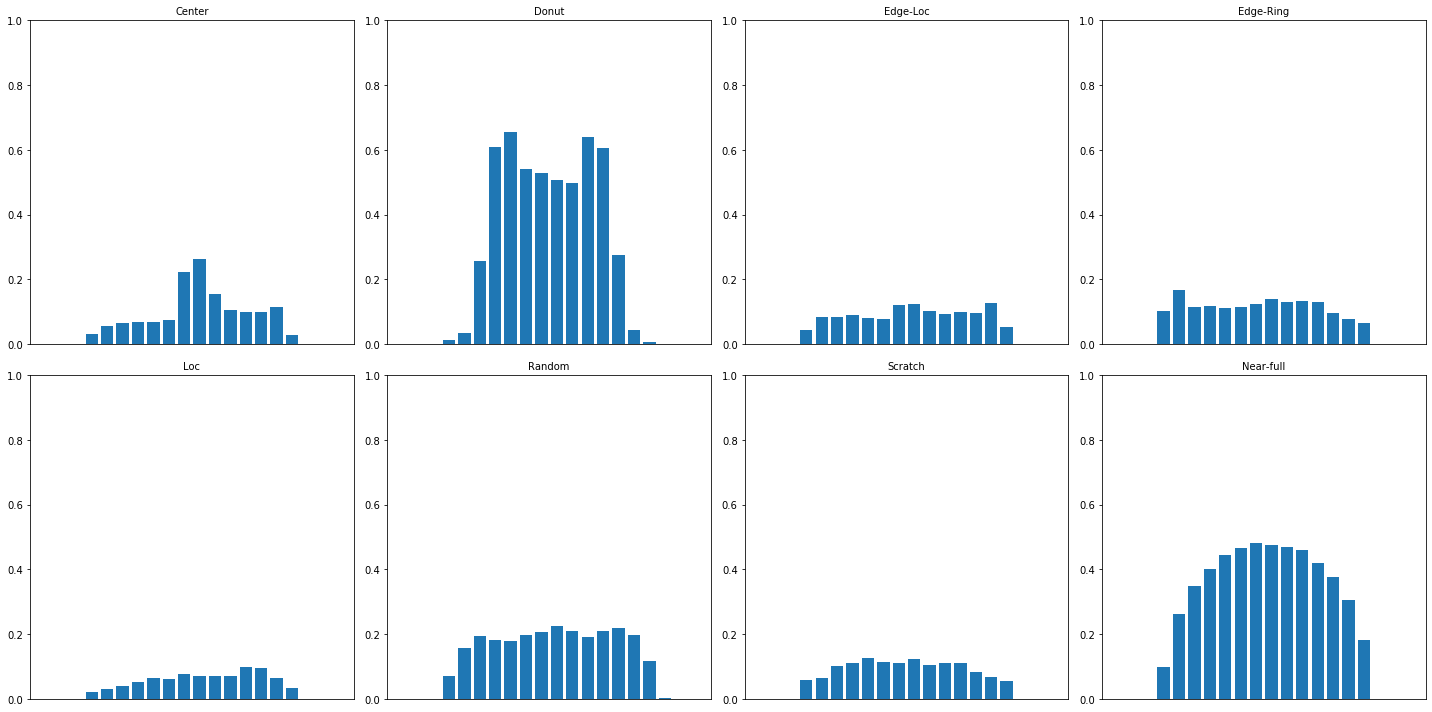

In [69]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_mean[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0,21])   
    ax[i].set_ylim([0,1])
plt.tight_layout()
plt.show() 

#### ラドン変換に基づく特徴量（行の標準偏差を加えたもの）

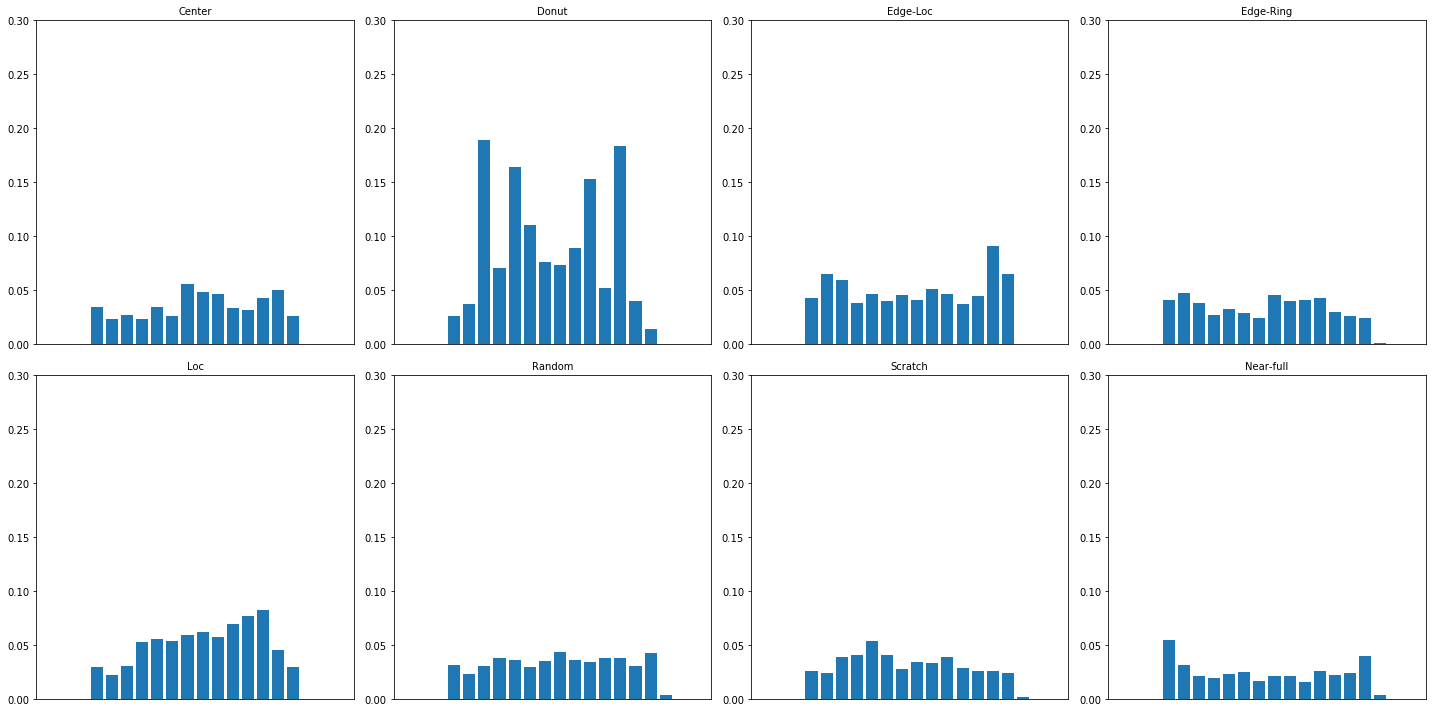

In [70]:
fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_std[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0,21])   
    ax[i].set_ylim([0,0.3])
plt.tight_layout()
plt.show() 

#### 幾何学的特徴量
- 最も顕著な領域の識別はノイズフィルタリングと見なすことができる．この研究では，region-labellingアルゴリズムを用いて，最も顕著な領域として最大面積の領域を選択する．
- 抽出した顕著な領域に対し，面積，周長，長軸，短軸の長さ，立体度，偏心度などの幾何学的特徴を抽出する．

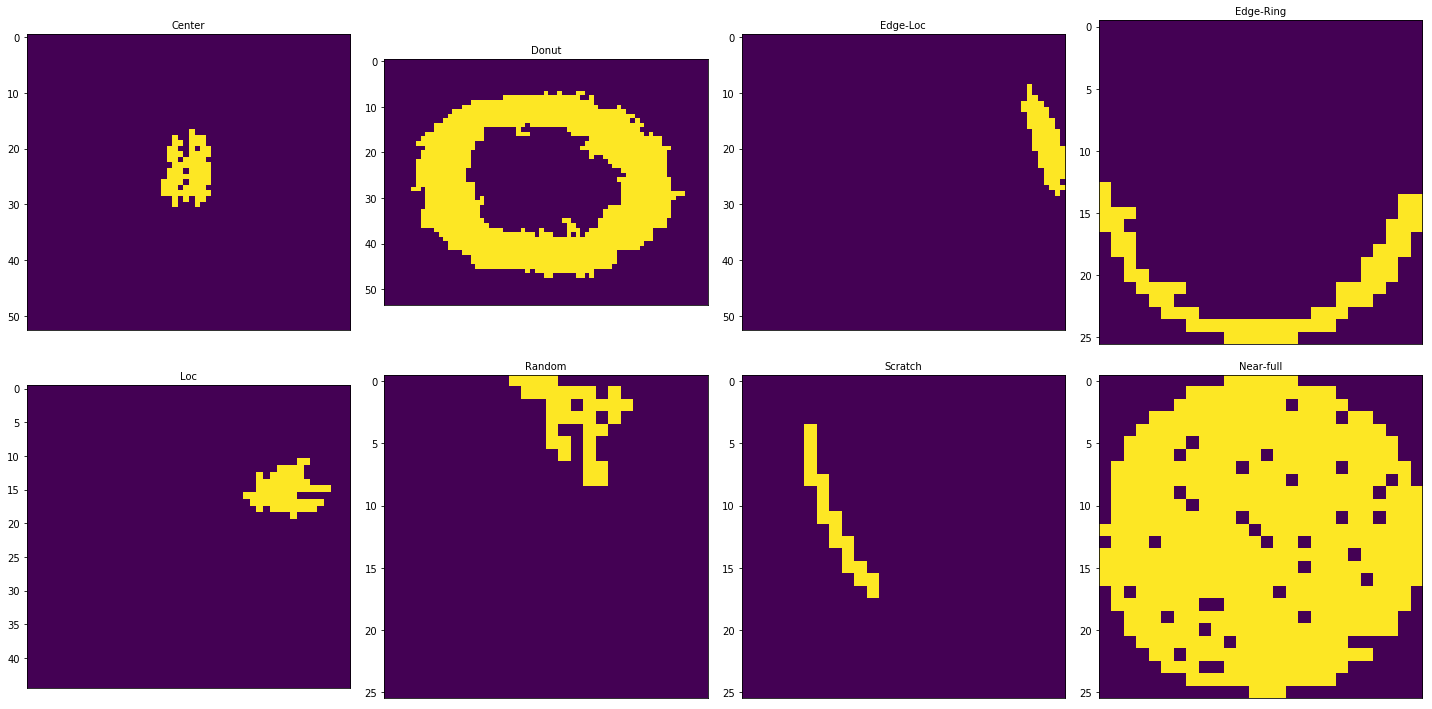

In [28]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    zero_img = np.zeros(img.shape)
    img_labels = measure.label(img, neighbors=4, connectivity=1, background=0)
    img_labels = img_labels-1
    if img_labels.max()==0:
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>-1], axis = None)
        no_region = info_region[0]
    
    zero_img[np.where(img_labels==no_region)] = 2 
    ax[i].imshow(zero_img)
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
plt.tight_layout()
plt.show() 

In [29]:
def cal_dist(img,x,y):
    dim0=np.size(img,axis=0)    
    dim1=np.size(img,axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist  

def fea_geom(img):
    norm_area=img.shape[0]*img.shape[1]
    norm_perimeter=np.sqrt((img.shape[0])**2+(img.shape[1])**2)
    
    img_labels = measure.label(img, neighbors=4, connectivity=1, background=0)

    if img_labels.max()==0:
        img_labels[img_labels==0]=1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>0], axis = None)
        no_region = info_region[0][0]-1       
    
    prop = measure.regionprops(img_labels)
    prop_area = prop[no_region].area/norm_area
    prop_perimeter = prop[no_region].perimeter/norm_perimeter 
    
    prop_cent = prop[no_region].local_centroid 
    prop_cent = cal_dist(img,prop_cent[0],prop_cent[1])
    
    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter 
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter  
    prop_ecc = prop[no_region].eccentricity  
    prop_solidity = prop[no_region].solidity  
    
    return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity

df_withpattern_copy['fea_geom'] =df_withpattern_copy.waferMap.apply(fea_geom)

In [30]:
df_withpattern_copy.fea_geom[340] #donut

(0.30881585811163276,
 3.463330562314747,
 0.7464951525564261,
 0.5214489845402418,
 0.715581129286252,
 0.6118863049095608)

*Donut*における面積，周長，長軸，短軸の長さ，立体度，偏心度などの幾何学的特徴を示した．

#### すべての特徴量をまとめる
- 密度特徴量：13次元
- ラドン変換に基づく特徴量：40次元
- 幾何学的特徴量:6次元
- 合計：13+40+6=59次元

In [31]:
df_all=df_withpattern_copy.copy()
a=[df_all.fea_reg[i] for i in range(df_all.shape[0])] #13
b=[df_all.fea_cub_mean[i] for i in range(df_all.shape[0])] #20
c=[df_all.fea_cub_std[i] for i in range(df_all.shape[0])] #20
d=[df_all.fea_geom[i] for i in range(df_all.shape[0])] #6
fea_all = np.concatenate((np.array(a),np.array(b),np.array(c),np.array(d)),axis=1) #59 in total

In [32]:
label=[df_all.failureNum[i] for i in range(df_all.shape[0])]
label=np.array(label)

### Step3：アルゴリズムの選択

#### 最も優れている機械学習のアルゴリズムはない
- どのアルゴリズムが問題解決に適しているかを事前に知ることはできない．

#### このモジュールではマルチクラスとマルチラベル学習のアルゴリズムを実装している
- one-vs-the-rest：この方法は1つのクラスに1つの分類器を適合させることで構成される．それぞれの分類器に対して，1つのクラスは他のすべてのクラスと異なり，適合する．
- one-vs-one：この方法はクラスのペアごとに1つの分類器を構築するものである．
- このデータセットの文献レビューに基づいて，モデルとしてOne-VS-OneマルチクラスSVMを選択した．

In [33]:
#import theano
#from theano import tensor as T
import tensorflow as T
from sklearn.cross_validation import train_test_split
from keras.utils import np_utils

X = fea_all
y = label

from collections import  Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)                      
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

RANDOM_STATE =42

Training target statistics: Counter({3: 7299, 2: 3860, 0: 3238, 4: 2677, 6: 905, 5: 640, 1: 404, 7: 116})
Testing target statistics: Counter({3: 2381, 2: 1329, 0: 1056, 4: 916, 6: 288, 5: 226, 1: 151, 7: 33})


GPU: 1
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


- トレーニングとテストは0.75:0.25

In [37]:
# ---multicalss classification ---# 
# One-Vs-One
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
clf2 = OneVsOneClassifier(LinearSVC(random_state = RANDOM_STATE)).fit(X_train, y_train)
y_train_pred = clf2.predict(X_train)
y_test_pred = clf2.predict(X_test)
train_acc2 = np.sum(y_train == y_train_pred, axis=0, dtype='float') / X_train.shape[0]
test_acc2 = np.sum(y_test == y_test_pred, axis=0, dtype='float') / X_test.shape[0]
print('One-Vs-One Training acc: {}'.format(train_acc2*100)) #One-Vs-One Training acc: 80.36
print('One-Vs-One Testing acc: {}'.format(test_acc2*100)) #One-Vs-One Testing acc: 79.04
print("y_train_pred[:100]: ", y_train_pred[:100])
print ("y_train[:100]: ", y_train[:100])

One-Vs-One Training acc: 80.36992528345263
One-Vs-One Testing acc: 79.04388714733543
y_train_pred[:100]:  [4 0 4 2 3 3 2 0 2 2 6 0 4 0 3 4 2 2 4 4 2 4 0 4 3 0 3 3 3 3 4 3 0 3 4 3 3
 4 3 4 2 3 3 3 0 6 3 3 4 3 0 3 2 2 2 0 3 3 4 0 4 2 3 3 3 3 4 3 0 3 4 4 0 4
 4 3 2 0 2 0 2 4 3 3 2 3 0 0 4 0 0 3 4 3 0 3 3 4 4 4]
y_train[:100]:  [5 0 4 2 0 3 2 0 2 2 6 0 4 0 3 0 6 2 2 5 2 4 0 5 3 0 3 3 3 3 2 3 4 3 4 3 3
 4 3 2 2 3 3 3 0 6 3 5 2 3 0 3 2 2 2 0 3 3 1 0 4 2 3 3 3 3 4 3 0 3 2 4 0 4
 2 3 3 0 2 0 2 4 3 3 4 3 0 0 6 0 0 3 4 3 0 3 3 2 4 2]


- 学習データの正答率：80.36%
- テストデータの正答率：79.04%

### Step4：結果
- パターン認識の混同行列

In [35]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    

Confusion matrix, without normalization
Normalized confusion matrix


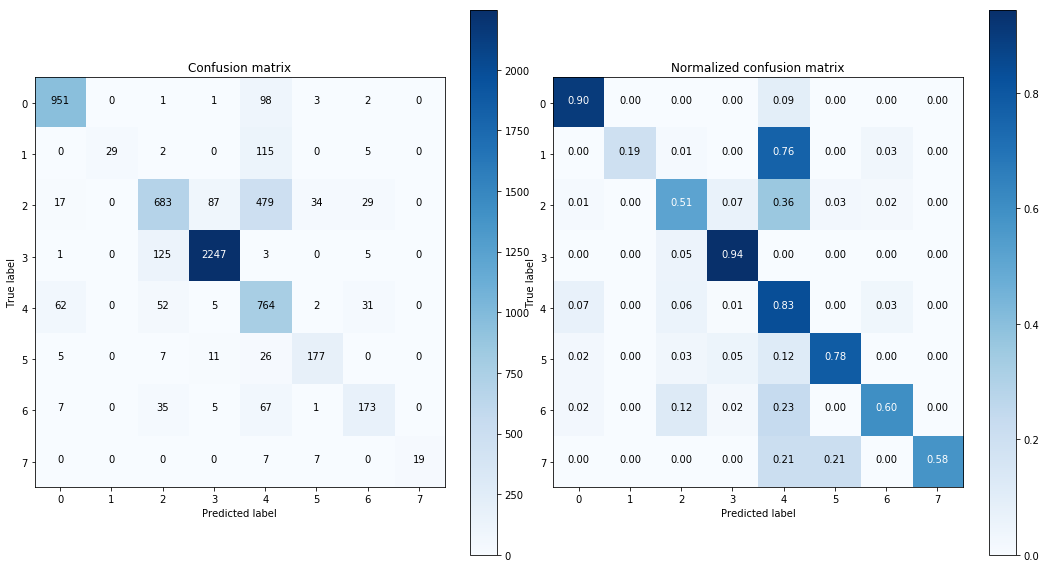

In [36]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()